In [31]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft
import lightgbm as lgb
from lightgbm import plot_tree
from graphviz import Digraph
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold,GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score,mean_squared_error
import time
import pickle
import gc

%matplotlib inline

# Load Data

In [68]:
with open('./data/df_train_total.pickle', 'rb') as handle:
    df_train_total = pickle.load(handle)
    
with open('./data/df_test_total.pickle', 'rb') as handle:
    df_test_total = pickle.load(handle)

In [69]:
df_train_total.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [70]:
df_test_total.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01,0,Education,7432,2008.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,1,1,0,2017-01-01,0,Education,2720,2004.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
2,2,2,0,2017-01-01,0,Education,5376,1991.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
3,3,3,0,2017-01-01,0,Education,23685,2002.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
4,4,4,0,2017-01-01,0,Education,116607,1975.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6


# Remove Strange Data

In [71]:
df_train_total = df_train_total.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

# Add Feature

In [72]:
# add hour feature
df_train_total["hour"] = df_train_total["timestamp"].dt.hour
df_test_total["hour"] = df_test_total["timestamp"].dt.hour

In [62]:
# drop useless feature
#df_train_total.drop(["timestamp"],inplace = True,axis=1)
#df_test_total.drop(["timestamp"],inplace = True,axis=1)

In [55]:
# log transform square feet
#df_train_total["square_feet"] = np.log(df_train_total["square_feet"])
#df_test_total["square_feet"] = np.log(df_test_total["square_feet"])

In [38]:
# add weekday feature
# 3fold improve ele reduce others
#df_train_total["weekend"] = df_train_total["timestamp"].dt.weekday
#df_test_total["weekend"] = df_test_total["timestamp"].dt.weekday

# Helper Function

In [73]:
def label_encoder(df, categorical_columns=None):
    """Encode categorical values as integers (0,1,2,3...) with pandas.factorize. """
    # if categorical_colunms are not given than treat object as categorical features
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    for col in categorical_columns:
        df[col], uniques = pd.factorize(df[col])
    return df, categorical_columns

In [74]:
df_train_total,colname = label_encoder(df_train_total, categorical_columns=['primary_use'])
df_test_total,colname = label_encoder(df_test_total, categorical_columns=['primary_use'])

# Train with Seperate Meter Type

## General Settings

In [75]:
params = {'objective':'regression',
          'boosting_type':'gbdt',
          'metric':'rmse',
          'learning_rate':0.1,
          'num_leaves': 2**8,
          'max_depth':-1,
          'colsample_bytree':0.5,# feature_fraction 0.7
          'subsample_freq':1,
          'subsample':0.7,
          'verbose':-1,
          'num_threads':8,
          'seed': 47,#42
                } 

In [76]:
category_cols = ['building_id', 'site_id', 'primary_use']
category_cols

['building_id', 'site_id', 'primary_use']

In [53]:
def fold_train_model(splits_num,features_train,labels_train,features_test,categorical):
    splits = splits_num
    folds = KFold(n_splits = splits,random_state=50)
    #folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=50)
    predictions = np.zeros(len(features_test))
    models = []
    ave_score = 0
    
    for fold_num, (trn_idx, val_idx) in enumerate(folds.split(features_train.values, labels_train.values)):
    #for fold_num, (trn_idx, val_idx) in enumerate(folds.split(features_train.values, features_train['building_id'])):
        print("Fold {}".format(fold_num))
        train_df, y_train_df = features_train.iloc[trn_idx], labels_train.iloc[trn_idx]
        valid_df, y_valid_df = features_train.iloc[val_idx], labels_train.iloc[val_idx]

        trn_data = lgb.Dataset(train_df, label=y_train_df,categorical_feature=categorical)
        val_data = lgb.Dataset(valid_df, label=y_valid_df,categorical_feature=categorical)

        valid_results = {}
        clf = lgb.train(params,
                        trn_data,
                        2000,#10000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds=500,
                        evals_result=valid_results)

        pred = clf.predict(valid_df)
        score = np.sqrt(mean_squared_error(y_valid_df, pred))
        ave_score += score / splits
        predictions += np.expm1(clf.predict(features_test)) / splits
        models.append(clf)
    return ave_score,predictions,models

In [77]:
def train_meter_type(meter_type,df_train_total,df_test_total,category_cols,splits_num):
    # prepare data
    df_type_train = df_train_total[df_train_total.meter == meter_type]
    # transfer label with log
    df_type_label = np.log1p(df_type_train['meter_reading'])
    df_type_train.drop(columns = ['meter','meter_reading'],inplace=True)
    df_type_train['timestamp'] = df_type_train['timestamp'].astype('int64') // 10**9

    df_type_test = df_test_total[df_test_total.meter == meter_type]
    df_type_row_id = df_type_test['row_id']
    df_type_test.drop(columns = ['row_id','meter'],inplace=True)
    df_type_test['timestamp'] = df_type_test['timestamp'].astype('int64') // 10**9
    
    # train model
    print('train model')
    ave_score,predictions_type,models = fold_train_model(splits_num,df_type_train,df_type_label,df_type_test,category_cols)
    print('ave socre is %s'%(ave_score))
    
    # get prediction
    print('get prediction')
    sub_type = pd.DataFrame({'row_id': df_type_row_id, 'meter_reading': predictions_type})
    #sub_type = pd.DataFrame({'row_id': df_type_row_id, 'meter_reading': np.expm1(predictions_type)})
    return sub_type,ave_score,models

## Train electricity

In [78]:
sub_ele_f,ave_score,model_ele = train_meter_type(0,df_train_total,df_test_total,category_cols,3)

train model
Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.25621	valid_1's rmse: 0.623194
Early stopping, best iteration is:
[98]	training's rmse: 0.354288	valid_1's rmse: 0.600363
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.249073	valid_1's rmse: 0.631083
[1000]	training's rmse: 0.222563	valid_1's rmse: 0.630446
[1500]	training's rmse: 0.20522	valid_1's rmse: 0.631464
Early stopping, best iteration is:
[1140]	training's rmse: 0.217046	valid_1's rmse: 0.630221
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.261427	valid_1's rmse: 0.693742
Early stopping, best iteration is:
[91]	training's rmse: 0.364557	valid_1's rmse: 0.667207
ave socre is 0.632596926839646
get prediction


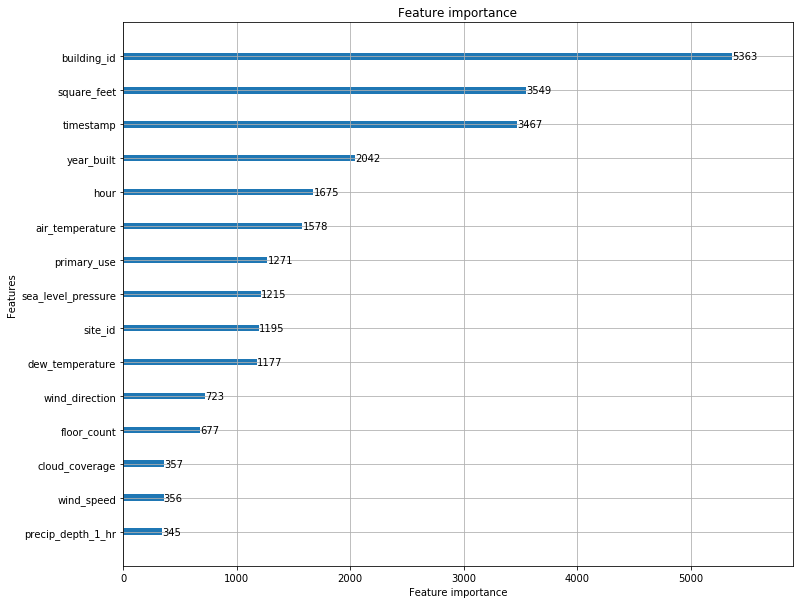

In [79]:
lgb.plot_importance(model_ele[0], max_num_features=20,figsize=(12,10))

In [80]:
sub_cw_f,ave_score_cw,model_cw = train_meter_type(1,df_train_total,df_test_total,category_cols,3)

train model
Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.598368	valid_1's rmse: 1.3901
Early stopping, best iteration is:
[130]	training's rmse: 0.766535	valid_1's rmse: 1.37493
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.613268	valid_1's rmse: 1.39931
Early stopping, best iteration is:
[87]	training's rmse: 0.843976	valid_1's rmse: 1.3803
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.588959	valid_1's rmse: 1.58167
Early stopping, best iteration is:
[106]	training's rmse: 0.771853	valid_1's rmse: 1.50304
ave socre is 1.4194229912442413
get prediction


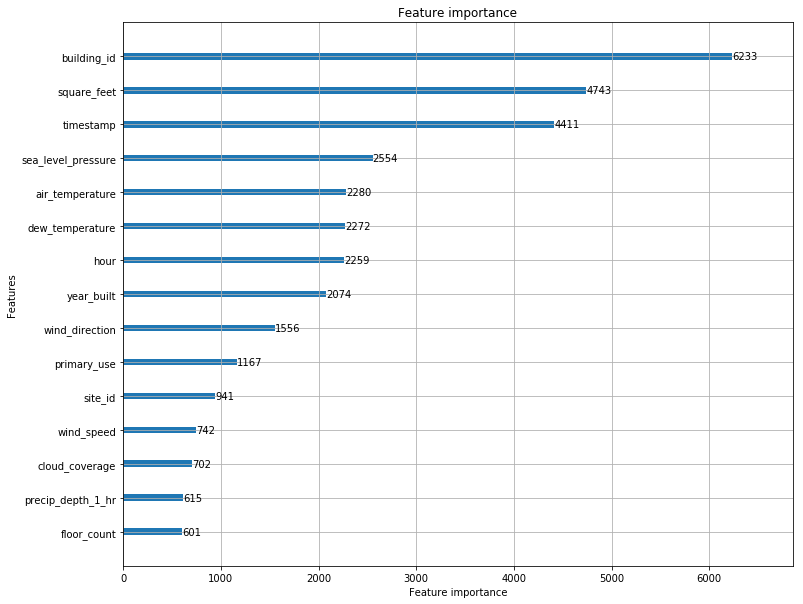

In [82]:
lgb.plot_importance(model_cw[0], max_num_features=20,figsize=(12,10))

In [83]:
sub_stm_f,ave_score_stm,model_stm = train_meter_type(2,df_train_total,df_test_total,category_cols,3)

train model
Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.775129	valid_1's rmse: 1.51442
Early stopping, best iteration is:
[94]	training's rmse: 0.931582	valid_1's rmse: 1.4714
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.700978	valid_1's rmse: 1.43095
[1000]	training's rmse: 0.63782	valid_1's rmse: 1.43237
Early stopping, best iteration is:
[659]	training's rmse: 0.675675	valid_1's rmse: 1.42923
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.763075	valid_1's rmse: 1.61452
Early stopping, best iteration is:
[48]	training's rmse: 1.01022	valid_1's rmse: 1.54016
ave socre is 1.4802630316164278
get prediction


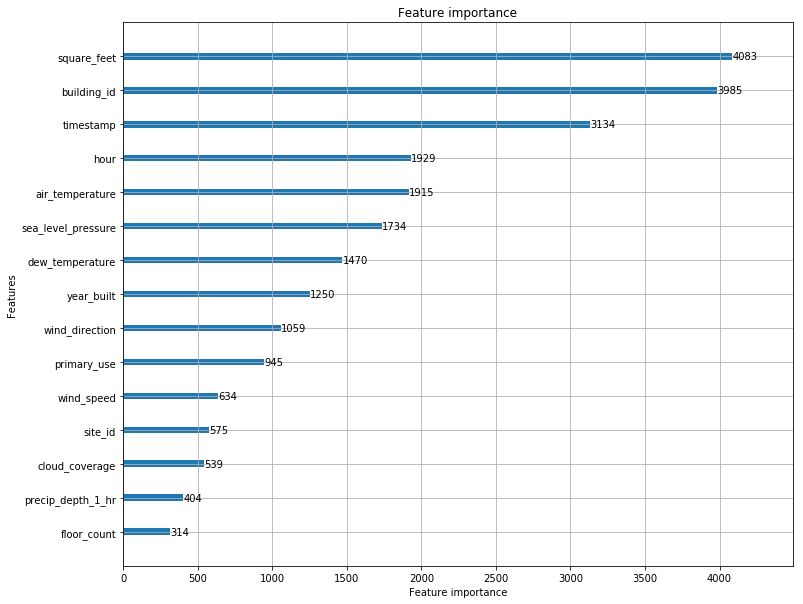

In [84]:
lgb.plot_importance(model_stm[0], max_num_features=20,figsize=(12,10))

In [ ]:
sub_hw_f,ave_score_hw,model_hw = train_meter_type(3,df_train_total,df_test_total,category_cols,3)

train model
Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.784399	valid_1's rmse: 1.85862
Early stopping, best iteration is:
[43]	training's rmse: 1.08503	valid_1's rmse: 1.70616
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.82633	valid_1's rmse: 1.36922
Early stopping, best iteration is:
[147]	training's rmse: 0.981914	valid_1's rmse: 1.35918


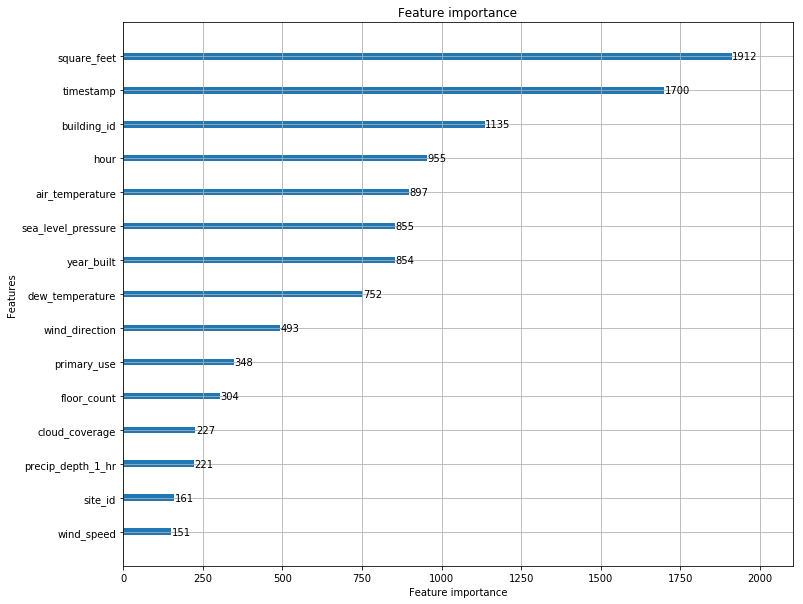

In [86]:
lgb.plot_importance(model_hw[0], max_num_features=20,figsize=(12,10))

In [87]:
# remove strange data and add hour feature change average method
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.2845213140796496

In [43]:
# five fold
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.1793592428754274

In [19]:
# remove strange data and add hour feature
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.284522580244981

In [65]:
# hour + log square feet feature
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.306757096342972

In [45]:
# hour + weekday feature
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.3276492832153732

In [35]:
# add hour feature
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.3065904018094043

In [15]:
# StratifiedKFold
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

0.7076236766552024

In [61]:
#huber
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.3604628852421023

In [51]:
# rmse
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.352893197767166

In [88]:
sub_all = pd.concat([sub_ele_f,sub_cw_f,sub_stm_f,sub_hw_f])
sub_all.sort_values(by='row_id')

,row_id,meter_reading
0,0,144.355488
1,1,93.369196
2,2,7.297914
3,3,245.194729
4,4,1081.518001
...,...,...
41697595,41697595,9.652741
41697596,41697596,4.323751
41697597,41697597,3.501898
41697598,41697598,149.472497


In [89]:
sub_all[sub_all.meter_reading < 0]

,row_id,meter_reading
4201945,4201945,-0.109488
4202233,4202233,-0.063021
4202522,4202522,-0.103220
4202811,4202811,-0.049984
4208302,4208302,-0.093585
...,...,...
4601987,4601987,-0.003077
4635222,4635222,-0.024987
7681571,7681571,-0.000417
8076864,8076864,-0.008501


In [47]:
sub_all.loc[sub_all.meter_reading < 0, 'meter_reading'] = 0

In [90]:
sub_all.to_csv('./data/baseline_log_rmdata_newave.csv', index = False)

In [27]:
#del sub_all
#gc.collect()

76